## Import necessary packages

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

## Import stock data from Yahoo finance

In [2]:
import yfinance as yahooFinance # Yahoo Finance has a nice API
tickers = ['^IXIC','MSFT','AAPL','NVDA','GOOGL',
           'AMZN','META','TSM','TSLA','JPM',
           'ASML','AMD','BABA','CSCO','PFE']
dfs = {ticker:yahooFinance.Ticker(ticker).history(period='max') for ticker in tickers}

## Visualize stock opening prices

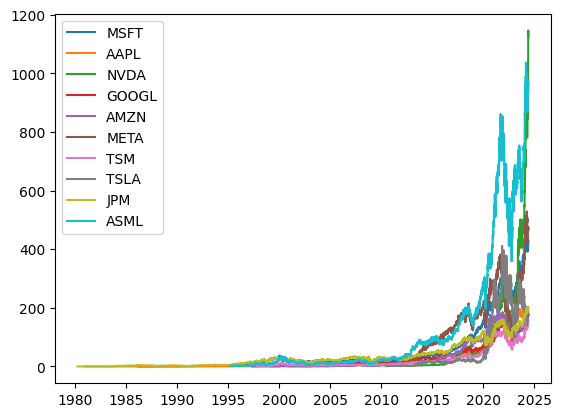

In [3]:
for ticker in tickers[1:11]:
    plt.plot(dfs[ticker].Open, label=ticker)

plt.legend()
plt.show()

## Define function to scale data

In [19]:
def scale_data(data_train, data_test):
    sc = MinMaxScaler(feature_range=(0,1))
    sc.fit(data_train)
    train_sc = pd.DataFrame(sc.transform(data_train), columns=data_train.columns)
    test_sc = pd.DataFrame(sc.transform(data_test), columns=data_train.columns)
    return sc, train_sc, test_sc

## Train_test split and scale data

In [189]:
stock = 'MSFT'
n_pred = 1

train = dfs[stock].iloc[:-n_pred]
test = dfs[stock].iloc[-n_pred:]

scaler, train_sc, test_sc = scale_data(train[['Open','High','Low','Close']], test[['Open','High','Low','Close']])

## Plot autocorrelation of differences of stock prices at various lags

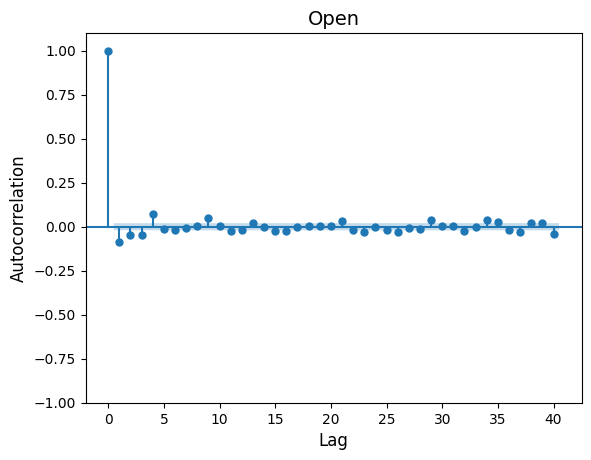

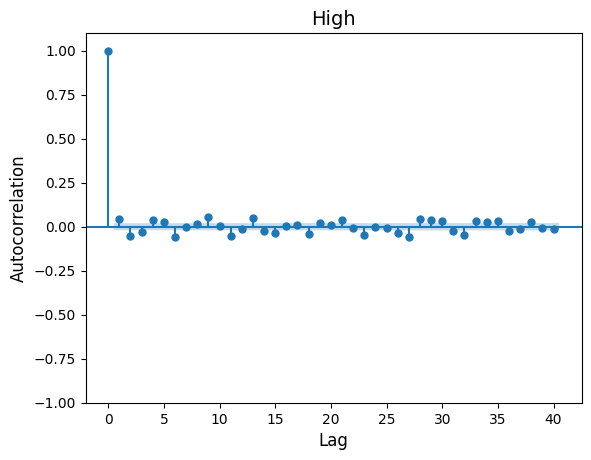

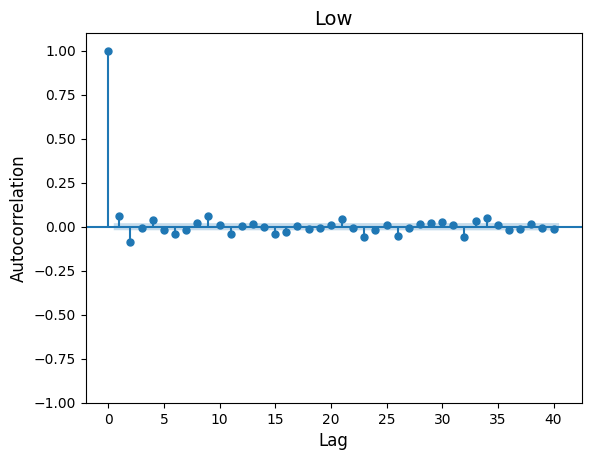

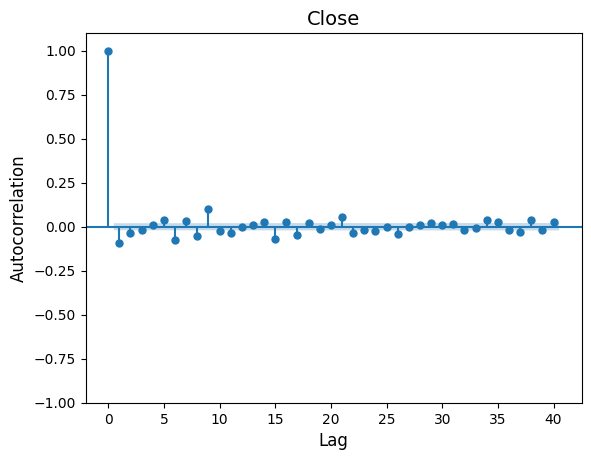

In [6]:
for feature in train_sc.columns[:4]:
    sm.graphics.tsa.plot_acf(train_sc[feature].diff().values[1:],
                               lags=40)

    plt.title('%s' %feature, fontsize=14)
    plt.ylabel("Autocorrelation", fontsize=12)
    plt.xlabel("Lag", fontsize=12)
    plt.ylim(-1.,1.1)

plt.show()

## Define parameters for cross-validation

In [7]:
n_splits = 10
kfold = TimeSeriesSplit(n_splits,test_size=n_pred)

## Perform rolling average, naive forecast and exponential smoothing and calculate RMSE

In [190]:
rmse_Gaussian = np.zeros((n_splits,4))
rmse_naive = np.zeros((n_splits,4))
rmse_exp_smooth = np.zeros((n_splits,4))

i = 0
for train_index, test_index in kfold.split(train):
    tt = train.iloc[train_index]
    val = train.iloc[test_index]

    sc, tt_sc, val_sc = scale_data(tt, val)
    
    tt_avg = []
    tt_naive = []
    tt_exp = []
    for price in train.columns[:4]:
        tt_avg.append(tt_sc[price].mean())
        tt_naive.append(tt_sc[price].values[-1])
        simp_exp_smooth = SimpleExpSmoothing(tt_sc[price]).fit(optimized=True)
        tt_exp.append(simp_exp_smooth.forecast(n_pred))
    # pred_avg = sc.inverse_transform(pd.DataFrame(np.array(tt_avg).reshape(1,-1)))
    # pred_naive = sc.inverse_transform(pd.DataFrame(np.array(tt_naive).reshape(1,-1)))
    # pred_exp = sc.inverse_transform(pd.DataFrame(np.array(tt_exp).reshape(1,-1)))

    j = 0
    for price in train.columns[:4]:
        # rmse_Gaussian[i,j] = np.sqrt(mean_squared_error(val[price].values,
        #                             pred_avg.flatten()[j]*np.ones(n_pred)))
        # rmse_naive[i,j] = np.sqrt(mean_squared_error(val[price].values,
        #                             pred_naive.flatten()[j]*np.ones(n_pred)))
        # rmse_exp_smooth[i,j] = np.sqrt(mean_squared_error(val[price].values,
        #                             pred_exp.flatten()[0].reshape(-1,1)))
        rmse_Gaussian[i,j] = np.sqrt(mean_squared_error(val_sc[price].values,
                                    tt_avg[j]*np.ones(n_pred)))
        rmse_naive[i,j] = np.sqrt(mean_squared_error(val_sc[price].values,
                                    tt_naive[j]*np.ones(n_pred)))
        rmse_exp_smooth[i,j] = np.sqrt(mean_squared_error(val_sc[price].values,
                                    np.array(tt_exp)[j].reshape(-1,1)))
        j = j + 1
    
    i = i + 1

cv_rmse_Gaussian = np.mean(rmse_Gaussian,axis=0)
cv_rmse_naive = np.mean(rmse_naive,axis=0)
cv_rmse_exp_smooth = np.mean(rmse_exp_smooth,axis=0)

In [191]:
cv_rmse_Gaussian

array([0.87119795, 0.87425274, 0.87243703, 0.87254483])

In [107]:
cv_rmse_naive

array([0.00772739, 0.00589783, 0.00744487, 0.00829978])

In [108]:
cv_rmse_exp_smooth

array([0.00796854, 0.00589783, 0.00744487, 0.00830849])

In [192]:
train_avg = []
train_naive = []
train_exp = []

final_rmse_Gaussian = np.zeros(4)
final_rmse_naive = np.zeros(4)
final_rmse_exp_smooth = np.zeros(4)

for price in train.columns[:4]:
    train_avg.append(train_sc[price].mean())
    train_naive.append(train_sc[price].values[-1])
    simp_exp_smooth = SimpleExpSmoothing(train_sc[price]).fit(optimized=True)
    train_exp.append(simp_exp_smooth.forecast(n_pred))

j = 0
for price in train.columns[:4]:
    final_rmse_Gaussian[j] = np.sqrt(mean_squared_error(test_sc[price].values,
                                    train_avg[j]*np.ones(n_pred)))
    final_rmse_naive[j] = np.sqrt(mean_squared_error(test_sc[price].values,
                                    train_naive[j]*np.ones(n_pred)))
    final_rmse_exp_smooth[j] = np.sqrt(mean_squared_error(test_sc[price].values,
                                    np.array(train_exp)[j].reshape(-1,1)))
    j = j + 1

In [193]:
final_rmse_Gaussian

array([0.84373476, 0.84182055, 0.82868353, 0.82399989])

In [111]:
final_rmse_naive

array([0.01822524, 0.01769139, 0.02275945, 0.02046634])

In [112]:
final_rmse_exp_smooth

array([0.01861874, 0.01769139, 0.02275946, 0.02397461])

## ARIMA 

In [62]:
auto_arima(train_sc.Open.values, trace=True, max_p=10, max_q=10)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=2.77 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-72305.574, Time=0.35 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-75338.986, Time=0.23 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.77 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-76532.473, Time=0.22 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-77718.633, Time=0.49 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=-78116.811, Time=0.69 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=-78373.882, Time=0.92 sec
 ARIMA(6,2,0)(0,0,0)[0]             : AIC=-78586.744, Time=1.01 sec
 ARIMA(7,2,0)(0,0,0)[0]             : AIC=-78750.771, Time=1.03 sec
 ARIMA(8,2,0)(0,0,0)[0]             : AIC=-79005.740, Time=1.05 sec
 ARIMA(9,2,0)(0,0,0)[0]             : AIC=-79121.351, Time=1.03 sec
 ARIMA(10,2,0)(0,0,0)[0]             : AIC=-79167.479, Time=3.05 sec
 ARIMA(10,2,1)(0,0,0)[0]             : AIC=-77918.283, Time=9.60 sec
 ARIMA(9,2,1)(0,0

ARIMA(order=(10, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [63]:
auto_arima(train_sc.High.values, trace=True, max_p=10, max_q=10)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=2.33 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-76573.865, Time=0.27 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-78721.539, Time=0.55 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-81209.629, Time=0.35 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-81743.328, Time=1.28 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-81797.847, Time=1.16 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-79845.271, Time=0.22 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-81223.498, Time=0.99 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-82034.839, Time=0.73 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=1.72 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-82439.251, Time=0.87 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=-82629.048, Time=1.50 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=-82505.067, Time=0.98 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=-82481.860, Time=1.38 sec
 ARIMA(0,2,3)(0,0,0

ARIMA(order=(0, 2, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [64]:
auto_arima(train_sc.Low.values, trace=True, max_p=10, max_q=10)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-80842.014, Time=0.69 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-75516.173, Time=0.39 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-77370.606, Time=0.29 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-79853.575, Time=0.41 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=2.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-80830.016, Time=1.20 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-80542.215, Time=2.26 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=-81110.025, Time=1.16 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-81198.323, Time=0.90 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=-81304.729, Time=1.11 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=1.67 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=-81290.474, Time=1.13 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=-81252.400, Time=1.17 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-81205.656, Time=1.79 sec

Best model:  ARIMA

ARIMA(order=(0, 2, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [67]:
auto_arima(train_sc.Close.values, trace=True, max_p=10, max_q=10)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-78623.012, Time=0.72 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-71757.403, Time=0.25 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-74891.170, Time=0.30 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=1.23 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-78688.506, Time=0.68 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=2.53 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=1.54 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-79272.002, Time=2.23 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=-79100.544, Time=1.72 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=-79150.849, Time=3.24 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=-79026.432, Time=1.32 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=-79256.558, Time=2.73 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=-78998.404, Time=2.22 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-79265.572, Time=6.29 sec

Best model:  ARIMA(1,2,3)

ARIMA(order=(1, 2, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [113]:
rmse_arima = np.zeros((n_splits,4))

i = 0
for train_index, test_index in kfold.split(train):
    tt = train.iloc[train_index]
    val = train.iloc[test_index]

    sc, tt_sc, val_sc = scale_data(tt, val)
    tt_arima = []

    arima = ARIMA(tt_sc.Open.values, order=(10,2,0)).fit()
    tt_arima.append(arima.forecast(n_pred))

    arima = ARIMA(tt_sc.High.values, order=(0,2,3)).fit()
    tt_arima.append(arima.forecast(n_pred))

    arima = ARIMA(tt_sc.Low.values, order=(0,2,3)).fit()
    tt_arima.append(arima.forecast(n_pred))

    arima = ARIMA(tt_sc.Close.values, order=(1,2,3)).fit()
    tt_arima.append(arima.forecast(n_pred))

    j = 0
    for price in train.columns[:4]:

        rmse_arima[i,j] = np.sqrt(mean_squared_error(val_sc[price].values,
                                    np.array(tt_arima)[j].reshape(-1,1)))
        j = j + 1
    
    i = i + 1

cv_rmse_arima = np.mean(rmse_arima, axis=0)

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertib

In [114]:
cv_rmse_arima

array([0.00779898, 0.00614706, 0.00739678, 0.00810481])

In [116]:
train_arima = []

final_rmse_arima = np.zeros(4)

arima = ARIMA(train_sc.Open.values, order=(10,2,0)).fit()
train_arima.append(arima.forecast(n_pred))

arima = ARIMA(train_sc.High.values, order=(0,2,3)).fit()
train_arima.append(arima.forecast(n_pred))

arima = ARIMA(train_sc.Low.values, order=(0,2,3)).fit()
train_arima.append(arima.forecast(n_pred))

arima = ARIMA(train_sc.Close.values, order=(1,2,3)).fit()
train_arima.append(arima.forecast(n_pred))

j = 0
for price in train.columns[:4]:

    final_rmse_arima[j] = np.sqrt(mean_squared_error(test_sc[price].values,
                                    np.array(train_arima)[j].reshape(-1,1)))
    j = j + 1

/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sumanaich/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [117]:
final_rmse_arima

array([0.02055544, 0.0176057 , 0.02095533, 0.02676643])

## Plotting cross-validation RMSE for different models

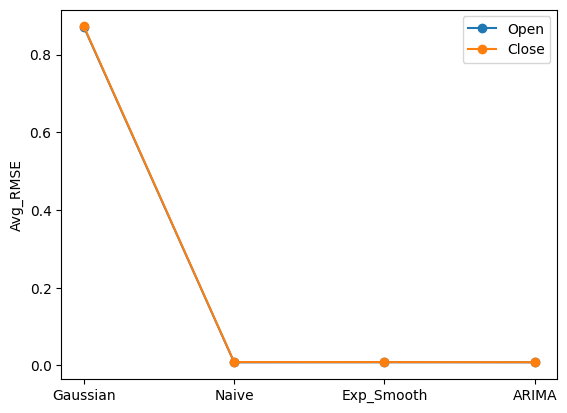

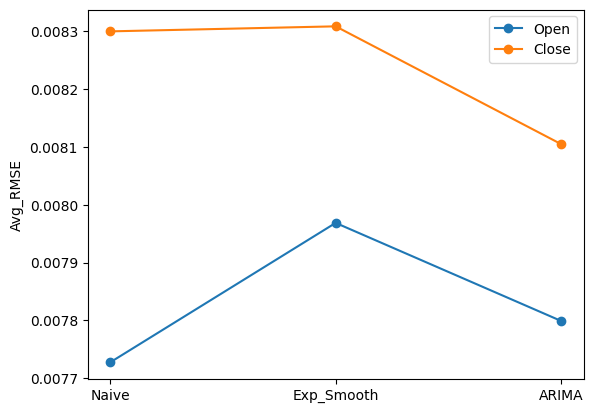

In [121]:
cv_rmse = np.array([cv_rmse_Gaussian,cv_rmse_naive,cv_rmse_exp_smooth,cv_rmse_arima])
for i in [0,3]:
    plt.plot(['Gaussian','Naive','Exp_Smooth','ARIMA'],cv_rmse[:,i],'-o',label=train.columns[i])

plt.ylabel('Avg_RMSE')
plt.legend(loc=0)
plt.show()

for i in [0,3]:
    plt.plot(['Naive','Exp_Smooth','ARIMA'],cv_rmse[1:,i],'-o',label=train.columns[i])

plt.ylabel('Avg_RMSE')
plt.legend(loc=0)
plt.show()

## Plotting final RMSE for different models

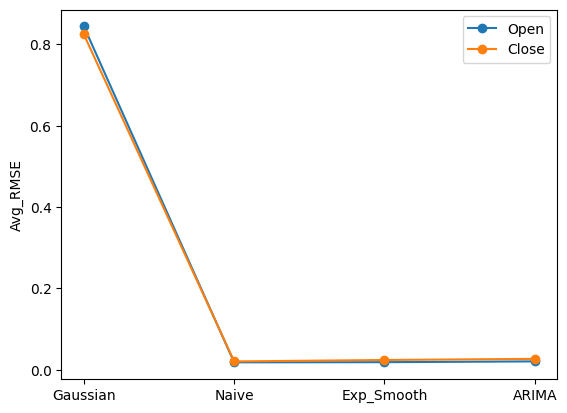

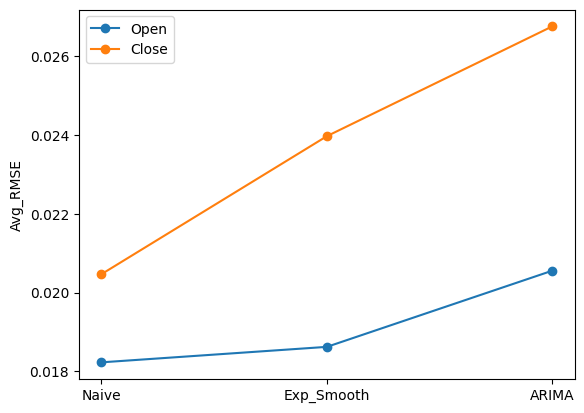

In [122]:
final_rmse = np.array([final_rmse_Gaussian,final_rmse_naive,final_rmse_exp_smooth,final_rmse_arima])
for i in [0,3]:
    plt.plot(['Gaussian','Naive','Exp_Smooth','ARIMA'],final_rmse[:,i],'-o',label=train.columns[i])

plt.ylabel('Avg_RMSE')
plt.legend(loc=0)
plt.show()

for i in [0,3]:
    plt.plot(['Naive','Exp_Smooth','ARIMA'],final_rmse[1:,i],'-o',label=train.columns[i])

plt.ylabel('Avg_RMSE')
plt.legend(loc=0)
plt.show()

## One day forecasts

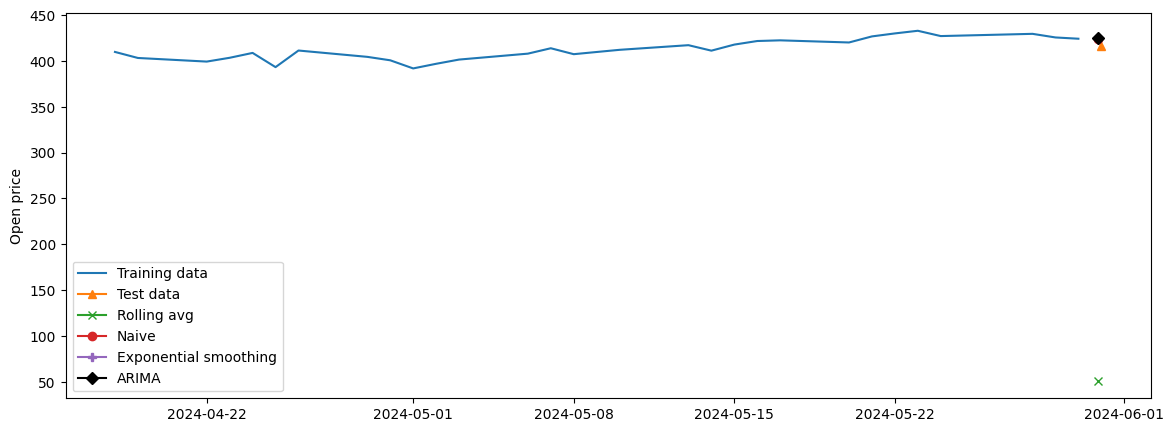

In [210]:
plt.figure(figsize=(14,5))

plt.plot(train['Open'][-30:], label="Training data")
plt.plot(test['Open'], label="Test data",marker="^")
plt.plot(datetime(2024,5,31),scaler.inverse_transform(pd.DataFrame(np.array(train_avg).reshape(1,-1)))[0,0], label="Rolling avg",marker="x")
plt.plot(datetime(2024,5,31),scaler.inverse_transform(pd.DataFrame(np.array(train_naive).reshape(1,-1)))[0,0], label="Naive",marker="o")
plt.plot(datetime(2024,5,31),scaler.inverse_transform(pd.DataFrame(np.array(train_exp).reshape(1,-1)))[0,0], label="Exponential smoothing",marker="P")
plt.plot(datetime(2024,5,31),scaler.inverse_transform(pd.DataFrame(np.array(train_arima).reshape(1,-1)))[0,0], label="ARIMA",marker="D", color='black')

plt.ylabel('Open price')
plt.legend()
plt.show()

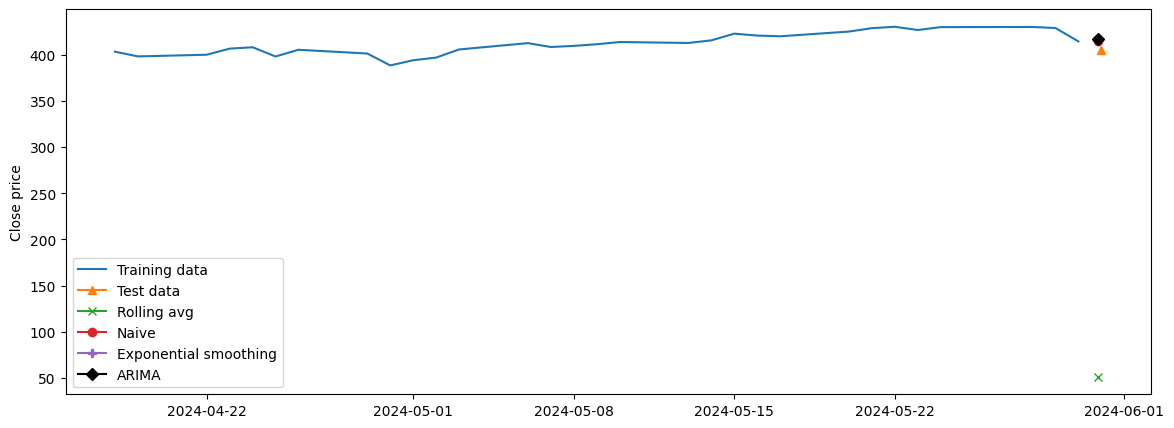

In [211]:
plt.figure(figsize=(14,5))

plt.plot(train['Close'][-30:], label="Training data")
plt.plot(test['Close'], label="Test data",marker="^")
plt.plot(datetime(2024,5,31),scaler.inverse_transform(pd.DataFrame(np.array(train_avg).reshape(1,-1)))[0,3], label="Rolling avg",marker="x")
plt.plot(datetime(2024,5,31),scaler.inverse_transform(pd.DataFrame(np.array(train_naive).reshape(1,-1)))[0,3], label="Naive",marker="o")
plt.plot(datetime(2024,5,31),scaler.inverse_transform(pd.DataFrame(np.array(train_exp).reshape(1,-1)))[0,3], label="Exponential smoothing",marker="P")
plt.plot(datetime(2024,5,31),scaler.inverse_transform(pd.DataFrame(np.array(train_arima).reshape(1,-1)))[0,3], label="ARIMA",marker="D", color='black')

plt.ylabel('Close price')
plt.legend()
plt.show()